# Explore Tara Geographically

In [1]:
from importlib import reload

import numpy as np
from datetime import datetime, time
import random 

import pandas
import geopandas
import seaborn as sns
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy
import corner

from oceancolor.tara import io as tara_io
from oceancolor.ph import pigments
from oceancolor.utils import cat_utils

from cnmf.oceanography import iops
from cnmf import zhu_nmf as nmf
from cnmf import io as cnmf_io

In [2]:
%matplotlib ipympl

In [3]:
tformM = ccrs.Mollweide()
tformP = ccrs.PlateCarree()

# Load

## Load up Tara fitted with L23

In [4]:
# Load Tara
N_NMF, iop = 4, 'a'
d_tara = cnmf_io.load_nmf('Tara_L23', N_NMF, iop)
tara_coeff = d_tara['coeff']
tara_wave = d_tara['wave']

In [27]:
tara_coeff.shape

(4, 40000)

In [5]:
list(d_tara.keys())

['M', 'coeff', 'spec', 'mask', 'err', 'wave', 'Rs', 'UID']

In [6]:
df_tfit = pandas.DataFrame()
df_tfit['a1'] = tara_coeff[0,:]
df_tfit['UID'] = d_tara['UID']

## Full data frame

In [7]:
df_tara = tara_io.load_pg_db(expedition='Microbiome', as_geo=True)

/home/xavier/Projects/Oceanography/python/ocean-color/oceancolor/tara/io.py:59: UserWarning: Duplicate times in Tara Oceans database
  warnings.warn("Duplicate times in Tara Oceans database")


### Cut down to NMF subset

In [29]:
mid = cat_utils.match_ids(d_tara['UID'], df_tara.UID.values)

In [30]:
df_tara = df_tara.iloc[mid,:]

# Examine high $a_1$

## Histogram first

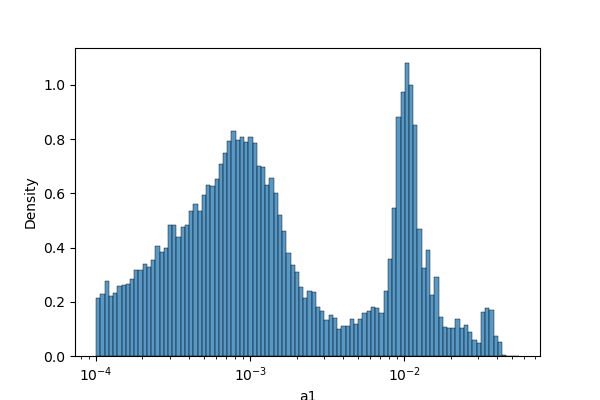

In [31]:
ss=0
df = df_tfit
keep = df[f'a{ss+1}'] > 1e-4
#
fig = plt.figure(figsize=(6,4))
ax = plt.gca()
sns.histplot(df[keep], x=f'a{ss+1}',
             bins=100, ax=ax,
        common_bins=True, stat='density', common_norm=False,
        log_scale=True)
plt.show()

## Geo me

In [32]:
high = df_tfit.a1 > 0.007

### Match IDs

In [33]:
hid = cat_utils.match_ids(df_tfit.UID.values[high], df_tara.UID.values)

In [34]:
high_tara = geopandas.GeoDataFrame(df_tara.iloc[hid])

<Axes: >

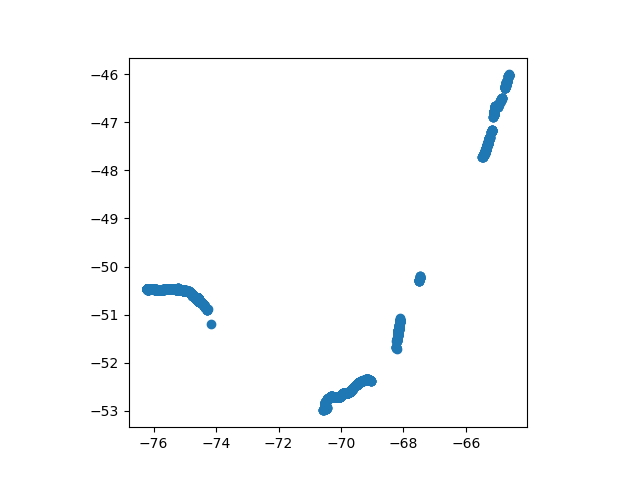

In [39]:
high_tara.plot()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


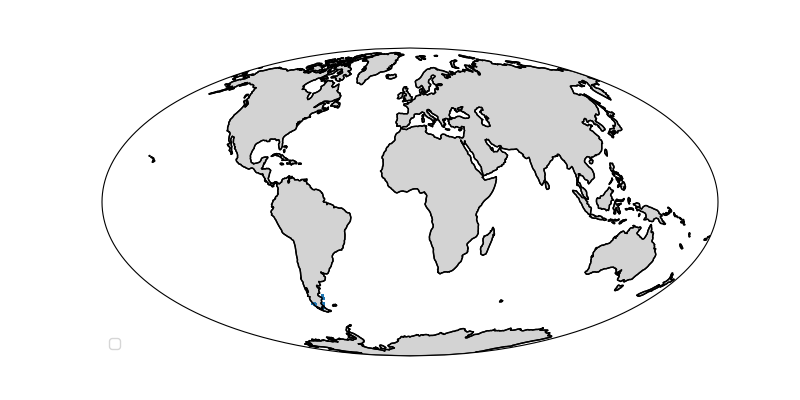

In [36]:
fig = plt.figure(figsize=(8,4))
plt.clf()

ax = plt.subplot(projection=tformM)

img = plt.scatter(x=high_tara.lon,
        y=high_tara.lat,
        #c=hp_plot[good], 
        #cmap=cm,
        #vmin=0.,
        #vmax=vmax, 
        s=1,
        transform=tformP)
                     #label=cruise)

# Coast lines
ax.coastlines(zorder=10)
ax.add_feature(cartopy.feature.LAND, 
    facecolor='lightgray', edgecolor='black')
ax.set_global()
ax.legend(loc='lower left')

plt.show()

## Other attributes

In [40]:
high_tara.Chl_lineheight

utc_dt
2021-02-02 16:18:00    2.632028
2021-02-02 16:19:00    2.749449
2021-02-02 16:20:00    2.667279
2021-02-02 16:21:00    2.725303
2021-02-02 16:22:00    2.849291
                         ...   
2021-02-28 13:48:00    3.483908
2021-02-28 13:49:00    3.481428
2021-02-28 13:50:00    3.548344
2021-02-28 13:51:00    3.580194
2021-02-28 13:52:00    3.609449
Name: Chl_lineheight, Length: 7519, dtype: float64

In [41]:
df_tara['Sample'] = 'Normal'
df_tara['Sample'].values[hid] = 'High'

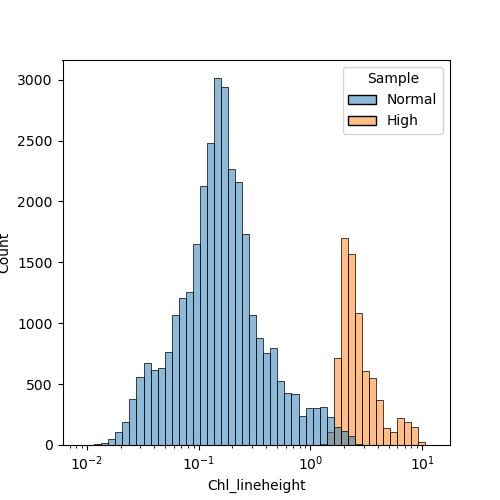

In [42]:
fig = plt.figure(figsize=(5,5))
sns.histplot(df_tara, x='Chl_lineheight', hue='Sample', bins=50,
            log_scale=True)
plt.show()